#1 - Librairies

In [ ]:
# install BERT tf
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 5.5MB/s 


In [ ]:
# import librairies for deep learning

#from __future__ import absolute_import, division, print_function, unicode_literals
#try:
  # %tensorflow_version only exists in Colab.
#  %tensorflow_version 2.x
#except Exception:
#  pass
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers
from keras.layers import Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from gensim.scripts.glove2word2vec import glove2word2vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from keras import backend as K
from matplotlib import pyplot
from gensim.models import word2vec
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, GRU, Conv1D, GlobalMaxPool1D
from keras.initializers import Constant
# test GloVe model 
from gensim.models import KeyedVectors
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import classification_report,confusion_matrix
# print tensorflow version
tf.__version__

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'1.15.0'

In [ ]:
# Initialize session
sess = tf.Session()
# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

# 2 - Functions

## 2.1 - functions to build BERT model

In [ ]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

In [ ]:
# Build model
def build_model(max_seq_length, opt, nb_trained_layers): 
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    # build BERT neural network model for classification
    # n_fine_tune_layers is the number of unfreezed layers (the ones that will be trained)
    bert_output = BertLayer(n_fine_tune_layers=nb_trained_layers, pooling="first")(bert_inputs)
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [ ]:
# define BERT layer
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'n_fine_tune_layers': self.n_fine_tune_layers,
            'trainable': self.trainable,
            'output_size': self.output_size,
            'pooling': self.pooling,
            'bert_path': self.bert_path,
        })
        return config

## 2.1 - text processing functions

In [ ]:
# remove urls
def remove_url(text):
    cleaned_text=re.sub(r'http\S+', '', text)
    return cleaned_text

In [ ]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [ ]:
def punctuation(sentence): 
    # punctuation marks 
    punctuations = '''[]|{}@#$%^\/_'''
    # traverse the given string and if any punctuation 
    # marks occur replace it with null 
    for x in sentence.lower(): 
        if x in punctuations: 
            sentence = sentence.replace(x, "") 
    return sentence

In [ ]:
def normalize_text(text):
  normalized_text=remove_url(text)
  normalized_text=clean_ascii(normalized_text)
  normalized_text=punctuation(normalized_text)
  return normalized_text

In [ ]:
tes="LonePine remembered around Australia as 'descendants' ^^ [] \/grow via 666canberra Gallipoli WW1\n"
tes

"LonePine remembered around Australia as 'descendants' ^^ [] \\/grow via 666canberra Gallipoli WW1\n"

In [ ]:
tes2=normalize_text(tes)
tes2

"LonePine remembered around Australia as 'descendants'   grow via 666canberra Gallipoli WW1\n"

## 2.3 - other helpful functions

In [ ]:
# plot training history (loss and accuracy metrics for training and validation set)
def plot_training_history(history):
  # plot loss and accuracy history
  from pylab import rcParams
  rcParams['figure.figsize'] = 13, 9
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  # plot accuracy during training
  pyplot.subplot(212)
  pyplot.title('Accuracy')
  pyplot.plot(history.history['acc'], label='train')
  pyplot.plot(history.history['val_acc'], label='test')
  pyplot.legend()
  pyplot.show()

In [ ]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# 3 - prepare input

## 3.1 - load data

In [ ]:
# connect to google Drive to import files
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# load data set
data="../gdrive/My Drive/colab/twitter_disaster/data/train_processed_data.csv"
df=pd.read_csv(data)
df.dropna(inplace=True)
df.isna().sum()

id              0
text            0
cleaned_text    0
target          0
dtype: int64

In [ ]:
#
#raw_text = df['text'].tolist()
#raw_text = [' '.join(t.split()[0:max_seq_length]) for t in text]
#raw_text = np.array(text, dtype=object)[:, np.newaxis]
#target = df['target'].tolist()
#text=np.array(text)
#target=np.array(target)

## 3.2 - preprocess text

In [ ]:
# transform to a normal text format (remove URLs, keep remove some punctuation charts including hashtags)
df['normalized_text']=df['text'].apply(lambda x: normalize_text(x))
text=df['normalized_text'].tolist()
# prepare for BERT inmput
max_seq_length=128
text = [' '.join(t.split()[0:max_seq_length]) for t in text]
text = np.array(text, dtype=object)[:, np.newaxis]
target = df['target'].tolist()
text=np.array(text)
target=np.array(target)

In [ ]:
# check text converted in a "conventional" format
df['normalized_text'].tolist()

['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school ',
 'RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - CAfire wildfires',
 'flood disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK f

## 3.3 - split into training set and validation set

In [ ]:
# split the data into a training set and a validation set
VALIDATION_SPLIT = 0.25
#indices =np.arange(tweets_pad.shape[0])
indices =np.arange(text.shape[0])
np.random.shuffle(indices)
text=text[indices]
target=target[indices]
num_validation_samples=int(VALIDATION_SPLIT*text.shape[0])

# training set
train_text=text[:-num_validation_samples]
train_label=target[:-num_validation_samples]

# validation set
val_text=text[-num_validation_samples:]
val_label=target[-num_validation_samples:]

print('shape of X_train_pad tensor:', train_text.shape)
print('shape of y_train tensor:', train_label.shape)

print('shape of X_test_pad tensor:', val_text.shape)
print('shape of y_test tensor:', val_label.shape)


shape of X_train_pad tensor: (5709, 1)
shape of y_train tensor: (5709,)
shape of X_test_pad tensor: (1903, 1)
shape of y_test tensor: (1903,)


## 3.4 - prepare the BERT inputs (id, mask, segment)

In [ ]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
val_examples = convert_text_to_examples(val_text, val_label)

# Convert to features
# training set
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
train_input=(train_input_ids, train_input_masks, train_segment_ids, train_labels )
# validation set
(val_input_ids, val_input_masks, val_segment_ids, val_labels
) = convert_examples_to_features(tokenizer, val_examples, max_seq_length=max_seq_length)
val_input= (val_input_ids, val_input_masks, val_segment_ids, val_labels)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
tf.__version__

'1.15.0'

# 4 - Training pipeline

## 4.1 - load pre-trained model

In [ ]:
# define optimizer
# lr=learning rate
from tensorflow.keras.optimizers import SGD
sgd = SGD(lr=0.001)

In [ ]:
# load BERT model pretrained on IMDB movies reviews
bert_pretrained_model=None
nb_trained_layers=6
bert_pretrained_model = build_model(max_seq_length, sgd, nb_trained_layers)
initialize_vars(sess)
#bert_pretrained_model.load_weights('../gdrive/My Drive/colab/pretrained_models/BertModel.h5', by_name=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_5 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

## 4.2 - Fine-tune BERT model with our data

### 4.2.2 - training model on data converted to conventional text format

In [ ]:
# train the classification model (4 epochs)
print('Training model...')
#history = model_bert.fit(X_train_pad, y_train, batch_size=30, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)
initialize_vars(sess)

history_pretrained_bert=bert_pretrained_model.fit( [train_input_ids, train_input_masks, train_segment_ids], train_labels, 
          validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels), epochs=7, batch_size=16)

Training model...
Train on 5709 samples, validate on 1903 samples
Epoch 1/7
5709/5709 [==============================] - 150s 26ms/sample - loss: 0.5599 - acc: 0.7294 - val_loss: 0.4803 - val_acc: 0.7782
Epoch 2/7
5709/5709 [==============================] - 144s 25ms/sample - loss: 0.4331 - acc: 0.8084 - val_loss: 0.4318 - val_acc: 0.8124
Epoch 3/7
5709/5709 [==============================] - 144s 25ms/sample - loss: 0.3954 - acc: 0.8343 - val_loss: 0.4053 - val_acc: 0.8213
Epoch 4/7
5709/5709 [==============================] - 144s 25ms/sample - loss: 0.3780 - acc: 0.8427 - val_loss: 0.4032 - val_acc: 0.8203
Epoch 5/7
5709/5709 [==============================] - 144s 25ms/sample - loss: 0.3581 - acc: 0.8525 - val_loss: 0.4003 - val_acc: 0.8313
Epoch 6/7
5709/5709 [==============================] - 145s 25ms/sample - loss: 0.3436 - acc: 0.8618 - val_loss: 0.4085 - val_acc: 0.8213
Epoch 7/7
5709/5709 [==============================] - 144s 25ms/sample - loss: 0.3285 - acc: 0.8688 - val

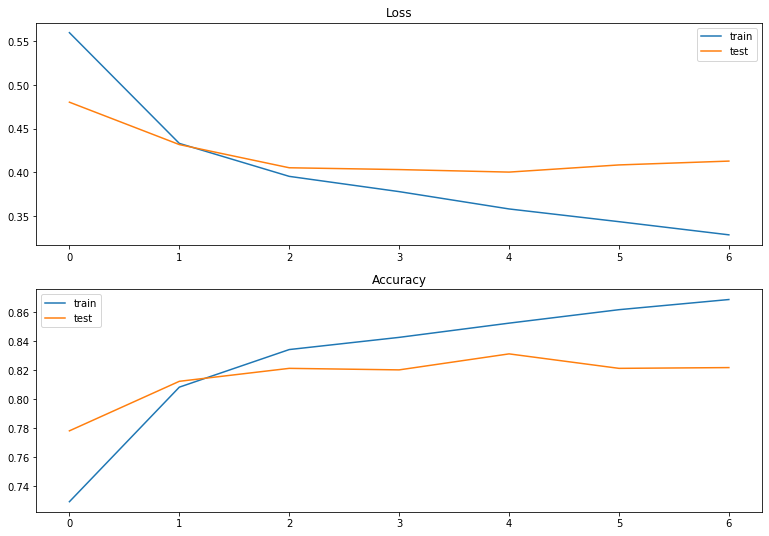

In [ ]:
plot_training_history(history_pretrained_bert)

### 4.2 - fit BERT on cleaned text (URLs and hashtags removed)


In [ ]:
# load BERT model pretrained on IMDB movies reviews
bert_pretrained_model_2=None
nb_trained_layers=7
bert_pretrained_model_2 = build_model(max_seq_length, sgd, nb_trained_layers)
initialize_vars(sess)
#bert_pretrained_model.load_weights('../gdrive/My Drive/colab/pretrained_models/BertModel.h5', by_name=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_6 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [ ]:
# train the classification model (4 epochs)
print('Training model...')
#history = model_bert.fit(X_train_pad, y_train, batch_size=30, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)
initialize_vars(sess)

history_pretrained_bert_2=bert_pretrained_model_2.fit( [train_input_ids, train_input_masks, train_segment_ids], train_labels, 
          validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels), epochs=7, batch_size=16)

Training model...
Train on 5709 samples, validate on 1903 samples
Epoch 1/7
5709/5709 [==============================] - 161s 28ms/sample - loss: 0.5590 - acc: 0.7203 - val_loss: 0.4806 - val_acc: 0.7730
Epoch 2/7
5709/5709 [==============================] - 154s 27ms/sample - loss: 0.4332 - acc: 0.8091 - val_loss: 0.4316 - val_acc: 0.8129
Epoch 3/7
5709/5709 [==============================] - 154s 27ms/sample - loss: 0.3930 - acc: 0.8308 - val_loss: 0.4225 - val_acc: 0.8203
Epoch 4/7
5709/5709 [==============================] - 154s 27ms/sample - loss: 0.3741 - acc: 0.8453 - val_loss: 0.4090 - val_acc: 0.8208
Epoch 5/7
5709/5709 [==============================] - 154s 27ms/sample - loss: 0.3560 - acc: 0.8546 - val_loss: 0.3996 - val_acc: 0.8345
Epoch 6/7
5709/5709 [==============================] - 154s 27ms/sample - loss: 0.3383 - acc: 0.8653 - val_loss: 0.4088 - val_acc: 0.8234
Epoch 7/7
5709/5709 [==============================] - 154s 27ms/sample - loss: 0.3219 - acc: 0.8693 - val

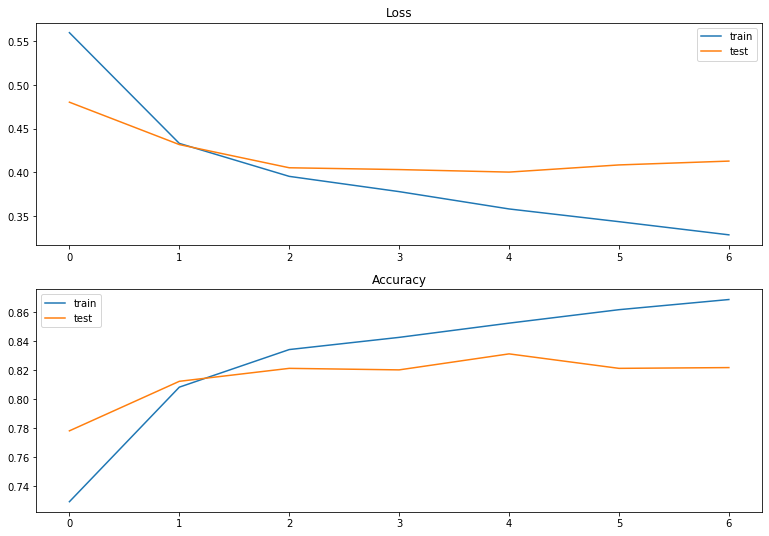

In [ ]:
plot_training_history(history_pretrained_bert)

## 4.3 - save model

In [ ]:
# save model and architecture to single file
bert_pretrained_model.save("../gdrive/My Drive/colab/pretrained_models/twitter_BertModel.h5")
print("Saved model to disk")

Saved model to disk


# 5 - Evaluate model performance

In [ ]:
# make predictions on validation set
val_input=[val_input_ids, val_input_masks, val_segment_ids]
val_pred_BERT = bert_pretrained_model_2.predict(val_input)
# round to 0 or 1 given the probability
val_pred_BERT_int = val_pred_BERT.round().astype('int')

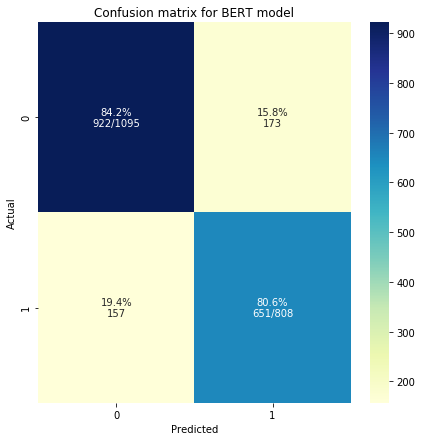

In [ ]:
# Showing Confusion Matrix for BERT model
plot_cm(val_pred_BERT_int, val_labels, 'Confusion matrix for BERT model', figsize=(7,7))

# 6 - Predictions on new data

## 6.1 - load and prepare imput data

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from bert import tokenization

In [ ]:
# load new data to make predictions
# load new data to make predictions
data="../gdrive/My Drive/colab/twitter_disaster/data/test_processed_data.csv"
df_new=pd.read_csv(data)
df_new['normalized_text']=df_new['text'].apply(lambda x: normalize_text(x))
text=df_new['normalized_text'].tolist()
df_new.fillna('-', inplace=True)
print('check missing values...')
df_new.isna().sum()
df_new['target_initialized']=0

text = df_new['text'].tolist()
text = [' '.join(t.split()[0:max_seq_length]) for t in text]
text = np.array(text, dtype=object)[:, np.newaxis]
target = df_new['target_initialized'].tolist()
text=np.array(text)
target=np.array(target)

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
data_pred = convert_text_to_examples(text, target)

# Convert to features

(input_ids, input_masks, segment_ids, labels
) = convert_examples_to_features(tokenizer, data_pred, max_seq_length=max_seq_length)

pred_input= (input_ids, input_masks, segment_ids, labels)

check missing values...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## 6.2 - make predictions

In [ ]:
# get probabilities 
test_pred_BERT = bert_pretrained_model.predict(pred_input)
# round to integer 0 or 1 to classify
test_pred_BERT_int = test_pred_BERT.round().astype('int')

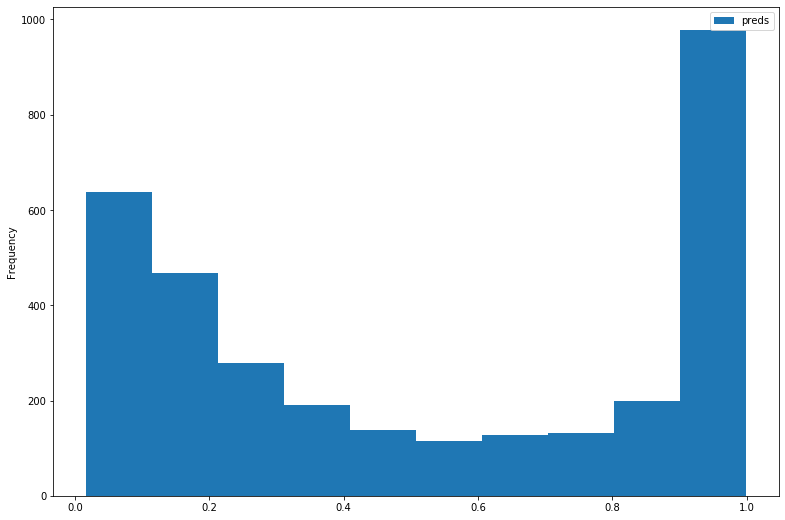

In [ ]:
# plot probabilities distribution
pred = pd.DataFrame(test_pred_BERT, columns=['preds'])
pred.plot.hist()

In [ ]:
# check predictions
predictions=pd.DataFrame(df_new['id'])
predictions['target']=test_pred_BERT_int
predictions['target'].value_counts()

0    2228
1    1035
Name: target, dtype: int64

In [ ]:
predictions.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## 6.3 - save results

In [ ]:
predictions.to_csv("../gdrive/My Drive/colab/twitter_disaster/submissions/predictions_bert.csv", index=False, header=True)